<a href="https://colab.research.google.com/github/DVN111/DQLab-Data-Science/blob/main/COSRX_Salicylic_Acid_Facewash_Sentiment_Analysis_on_X(Twittter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Pastikan kamu sudah mengunduh dataset twitter dan library nltk
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

In [3]:
df = pd.read_csv('/content/twit_kosmetik.csv')
df.head()
df.shape

(140, 15)

In [4]:
df = df[['full_text']]
df.shape

(140, 1)

In [5]:
# Fungsi preprocessing
def preprocess_tweet(tweet):
    # Hapus URL
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

    # Hapus @username
    tweet = re.sub(r'\@\w+|\#','', tweet)

    # Hapus angka dan tanda baca
    tweet = re.sub(r'\d+', '', tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Tokenisasi
    tokens = word_tokenize(tweet)

    # Stopword filtering dan negation handling
    stop_words = set(stopwords.words('indonesian'))
    tokens = ['tidak_'+word if word in ['tidak', 'bukan'] else word for word in tokens if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

tweets = df['full_text'].tolist()
# Preprocess tweet
processed_tweets = [preprocess_tweet(tweet) for tweet in tweets]

df['full_text'] = processed_tweets
df.shape

(140, 1)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
pretrained= "indobenchmark/indobert-base-p1"
# Inisialisasi model sentiment analysis untuk Bahasa Indonesia
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_pipeline = pipeline("sentiment-analysis", model=model,tokenizer=tokenizer)

df['sentiment'] = df['full_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}
df['sentiment'] = df['sentiment'].map(label_index)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,full_text,sentiment
0,skrg ni boikot cosrx sesiapa yg nak beralih ar...,negative
1,wt prelov skincar cosrx salicyl acid daili gel...,positive
2,wt want to sell prelov face wash cosrx salicyl...,negative
3,skincar ga kenal gender cowo cew aja cosrx sal...,negative
4,wt prelov salicyl acid daili gentl cleanser ex...,negative


In [8]:
df.head(20)

,full_text,sentiment
0,skrg ni boikot cosrx sesiapa yg nak beralih ar...,negative
1,wt prelov skincar cosrx salicyl acid daili gel...,positive
2,wt want to sell prelov face wash cosrx salicyl...,negative
3,skincar ga kenal gender cowo cew aja cosrx sal...,negative
4,wt prelov salicyl acid daili gentl cleanser ex...,negative
5,wt prelov fw cosrx salicyl acid pake kali byk ...,negative
6,wt cosrx salicyl acid facialwash isinya dom pa...,negative
7,wt want to sell jual cosrx salicyl acid daili ...,negative
8,wt facial wash fw cosrx salicyl acid origin be...,negative
9,wt skincar prelov corsx cleanser salicyl acid ...,negative


In [10]:
df = df.dropna()
# Feature extraction
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['full_text'])
labels = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Klasifikasi dengan Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.9285714285714286
Laporan Klasifikasi:
               precision    recall  f1-score   support

    negative       0.93      1.00      0.96        26
     neutral       0.00      0.00      0.00         1
    positive       0.00      0.00      0.00         1

    accuracy                           0.93        28
   macro avg       0.31      0.33      0.32        28
weighted avg       0.86      0.93      0.89        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


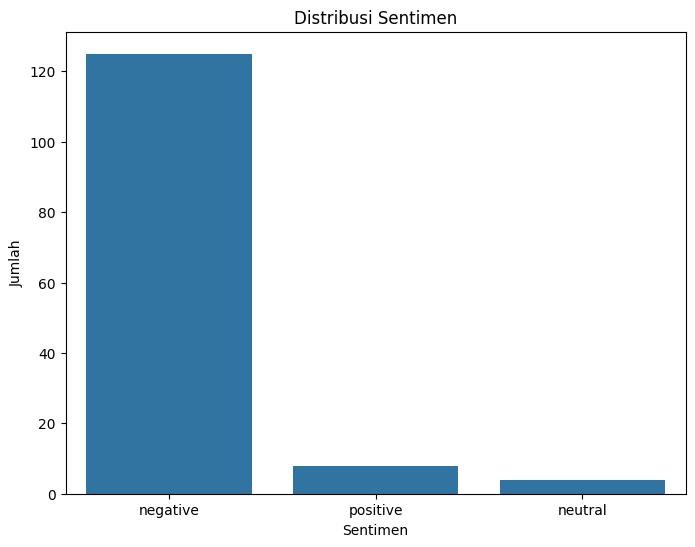

In [11]:
# prompt: buatkan plot untuk mengukur positif, negatif dan neutral

# Menghitung jumlah sentimen
sentiment_counts = df['sentiment'].value_counts()

# Membuat plot bar
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen')
plt.show()
